In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF , ConstantKernel as C


import scipy.interpolate


np.random.seed(1)

In [2]:
def import_data():
    
    prio_yearly = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO-GRID Yearly Variables for 1946-2014 - 2018-08-21.csv")
    feature_list = ['gid','year','pop_gpw_sum','gcp_ppp','urban_ih','agri_ih','forest_ih']
    prio_yearly_lean = prio_yearly[feature_list]

    return(prio_yearly_lean)


# proof of concept: 

In [3]:
df = import_data()
df_s = df.sample(1000, random_state = 123)
y_list = ['pop_gpw_sum','gcp_ppp','urban_ih','agri_ih','forest_ih']


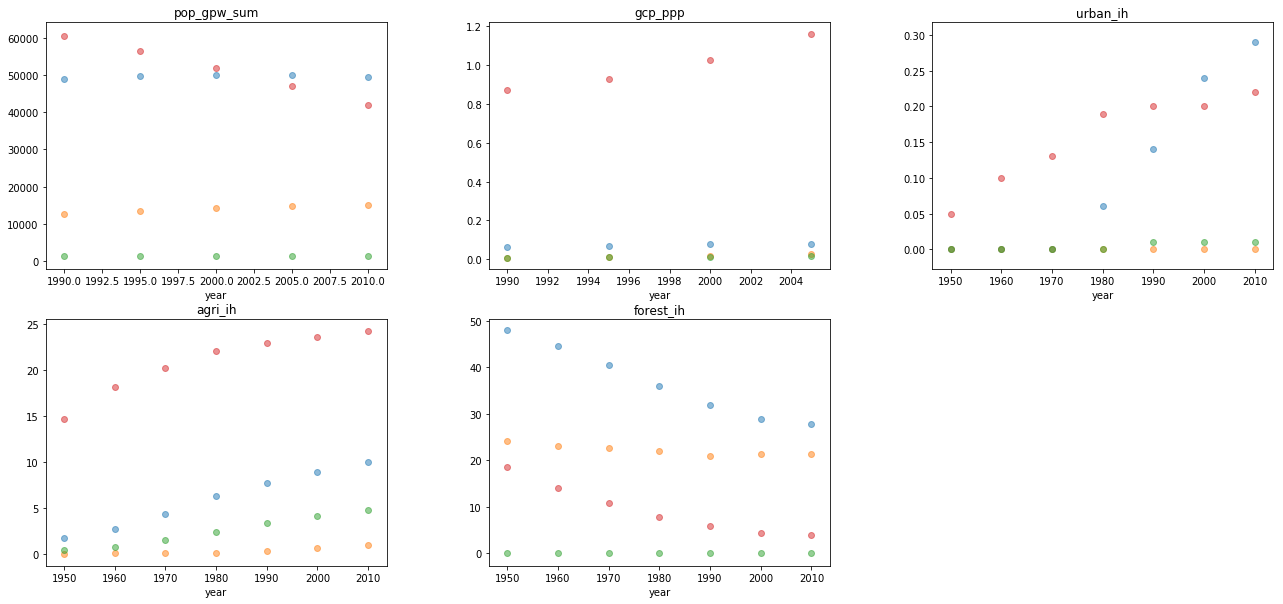

In [4]:
def scatter_year():
    
    # semi random obs:
    df_ex1 = df[df['gid']==110436].copy()
    df_ex2 = df[df['gid']==171920].copy()
    df_ex3 = df[df['gid']==108258].copy()
    df_ex4 = df[df['gid']==189791].copy()

    df_ex_list = [df_ex1, df_ex2, df_ex3, df_ex4]
    
    var_list = y_list
    nfeatures = len(var_list)
    cols=3 
    rows=math.ceil(nfeatures/cols)
    
    fig = plt.figure(figsize = (22,10))
    fig.subplots_adjust(hspace = 0.2, wspace = 0.3)
        
    for i in range(1,nfeatures+1):
        plt.subplot(rows,cols,i)
        
        for j in df_ex_list:
            plt.scatter(data=j, y=var_list[i-1], x='year',alpha = 0.5)
            #plt.plot(j['year'], j[var_list[i-1]], '-')

        plt.title(var_list[i-1])
        plt.xlabel('year')
        
    plt.show()

scatter_year()

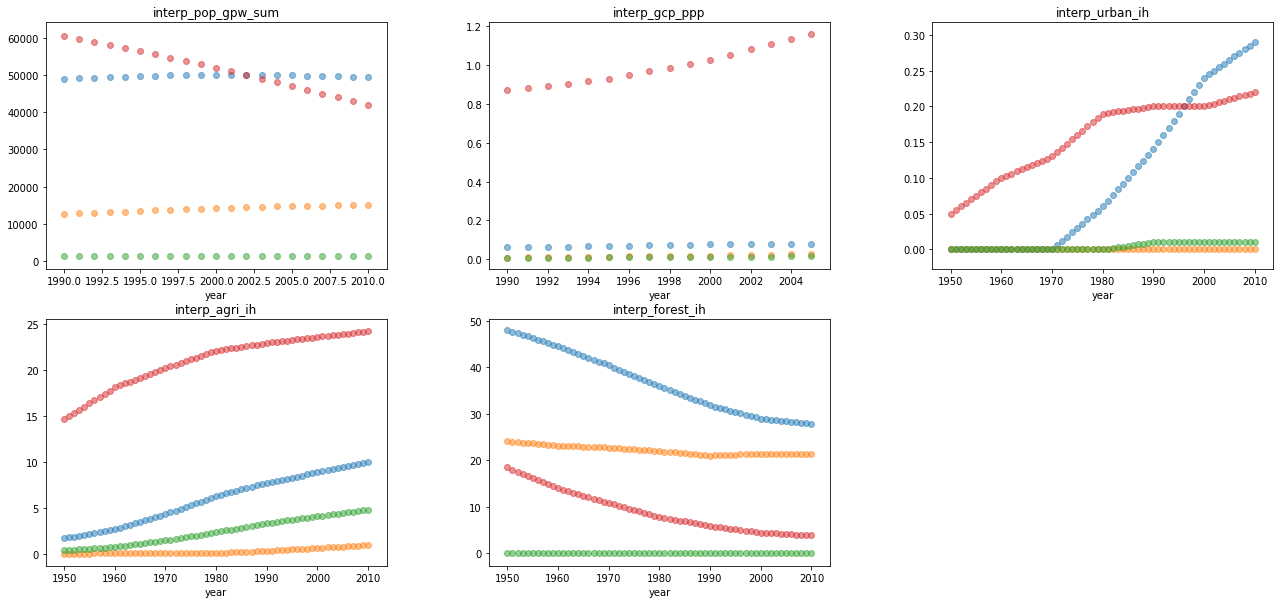

In [5]:
def scatter_year_interp():

    df_ex1 = df[df['gid']==110436].copy()
    df_ex2 = df[df['gid']==171920].copy()
    df_ex3 = df[df['gid']==108258].copy()
    df_ex4 = df[df['gid']==189791].copy()

    df_ex_list = [df_ex1, df_ex2, df_ex3, df_ex4]

    var_list = []

    for df_ex in df_ex_list:
        for feature in y_list:

            observations = df_ex[[feature,'year']].dropna()

            X = observations.iloc[:,1]
            y = observations.iloc[:,0]

            y_interp = scipy.interpolate.interp1d(X, y, bounds_error = False)
            interp_y = y_interp(df_ex['year'])

            feature_name = 'interp_' + feature
            df_ex[feature_name] = interp_y

            if feature_name not in var_list:
                var_list.append(feature_name)


    nfeatures = len(var_list)
    cols=3 
    rows=math.ceil(nfeatures/cols)

    fig = plt.figure(figsize = (22,10))
    fig.subplots_adjust(hspace = 0.2, wspace = 0.3)

    for i in range(1,nfeatures+1):
        plt.subplot(rows,cols,i)

        for j in df_ex_list:
            plt.scatter(data=j, y=var_list[i-1], x='year',alpha = 0.5)

        plt.title(var_list[i-1])
        plt.xlabel('year')

    plt.show()

scatter_year_interp()

Så det her er vejen frem.
spørgsmålet er om du selv skal køre det her fra eller bruge pandas inbyggede function (se https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate)

# Implementation:

In [6]:
df_test = df.copy()
for feature in y_list:
    feature_name = 'interp_' + feature
    df_test[feature_name] = np.full(df_test.shape[0], np.nan)

# OLD: 
est 50 hours

In [32]:

time_start = time.time()

#gids = df['gid'].unique() # all 64818 gids...
gids = df['gid'].unique()[np.random.randint(0, gids.shape[0],100)] # random sample 100
#gids = np.array([110436, 171920, 108258, 189791]) #semi random test set

for gid in gids:
    
    for feature in y_list:
        
        observations = df[df['gid']==gid][[feature,'year']].dropna()

        X = observations.iloc[:,1]
        y = observations.iloc[:,0]
    
        if len(y) > 1: # must have at least two entries
            y_interp = scipy.interpolate.interp1d(X, y, bounds_error = False)
            
            
            feature_name = 'interp_' + feature
        
            
            for observation_n in df_test[df['gid']==gid].index:
            
                df_test.at[observation_n, feature_name] = y_interp(df_test[df['gid']==gid]['year'][observation_n])
            

time_end = time.time()
print('{} minutes to complet'.format(round((time_end-time_start)/60, 2)))

4.38 minutes to complet


sooo... It works. no doubt. But it takes way to long time. est. 50 hours... How to vectorize/list comprhension... 

# NEW:
est. 2 hours

In [33]:
for feature in y_list:
    feature_name = 'interp_' + feature
    df[feature_name] = np.full(df_test.shape[0], np.nan)

In [34]:

time_start = time.time()

gids = df['gid'].unique() # all 64818 gids...
#gids = df['gid'].unique()[np.random.randint(0, gids.shape[0],100)] # random sample 100
#gids = np.array([110436, 171920, 108258, 189791]) #semi random test set

for gid in gids:
    
    for feature in y_list:
        
        observations = df[df['gid']==gid][[feature,'year']].dropna()

        X = observations.iloc[:,1]
        y = observations.iloc[:,0]
    
        if len(y) > 1: # must have at least two entries
            y_interp = scipy.interpolate.interp1d(X, y, bounds_error = False)
            
            
            feature_name = 'interp_' + feature
        
            observations_index = df[df['gid']==gid].index
            df.loc[observations_index,feature_name] = y_interp(df[df['gid']==gid]['year'])

            
#             for observation_n in df_test[df['gid']==gid].index:
            
#                 df_test.at[observation_n, feature_name] = y_interp(df_test[df['gid']==gid]['year'][observation_n])
            

time_end = time.time()
print('{} minutes to complet'.format(round((time_end-time_start)/60, 2)))

260.89 minutes to complet


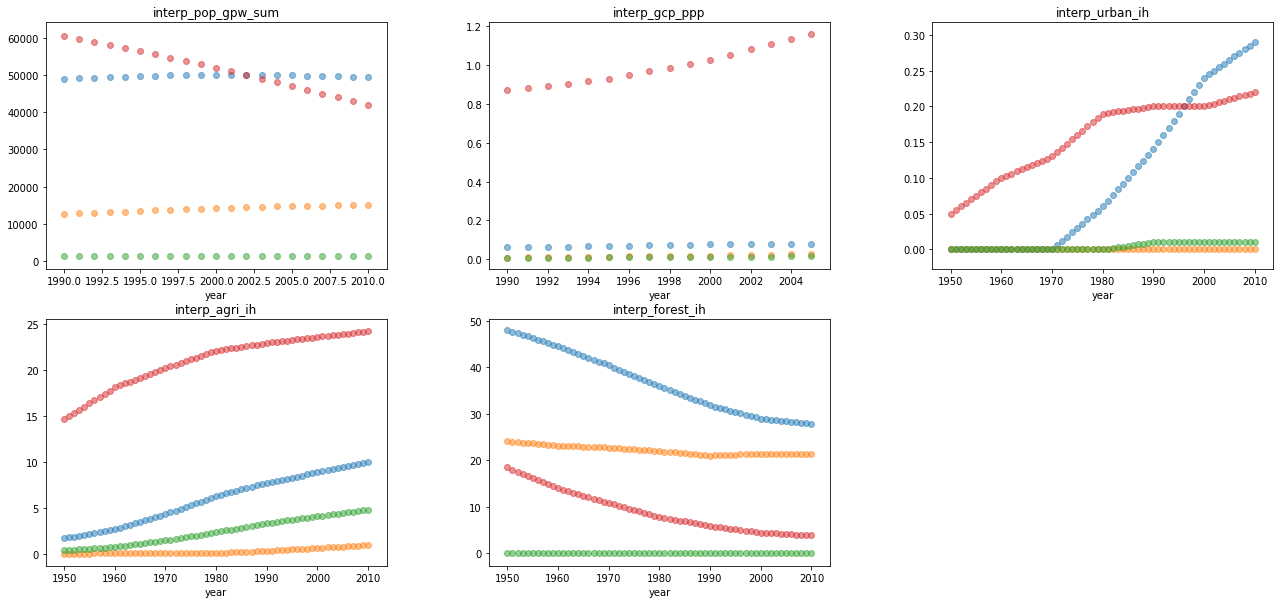

In [43]:
#Known test:

def scatter_year_interp_final():

    gid_list = [110436, 171920, 108258, 189791]

    var_list = []
    
    for f in y_list:
        feature_name = 'interp_' + f
        var_list.append(feature_name)

    nfeatures = len(var_list)
    cols=3 
    rows=math.ceil(nfeatures/cols)

    fig = plt.figure(figsize = (22,10))
    fig.subplots_adjust(hspace = 0.2, wspace = 0.3)

    for i in range(1,nfeatures+1):
        plt.subplot(rows,cols,i)

        for gid in gid_list:
            plt.scatter(data=df[df['gid']==gid], y=var_list[i-1], x='year',alpha = 0.5)

        plt.title(var_list[i-1])
        plt.xlabel('year')

    plt.show()

scatter_year_interp_final()

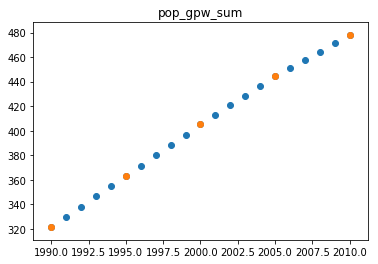

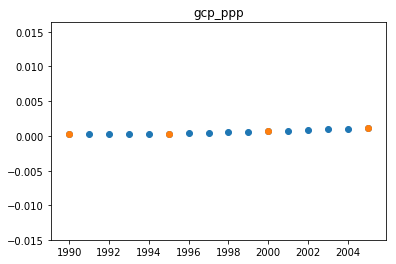

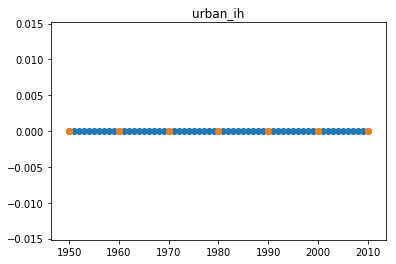

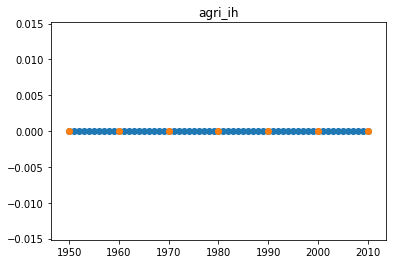

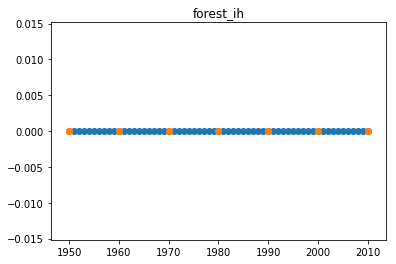

In [37]:
# random test:

n=30000

for f in y_list:
    feature_name = 'interp_' + f
    
    plt.title(f)
    plt.scatter(y = df[df['gid']==gids[n]][feature_name], x= df[df['gid']==gids[n]]['year'])
    plt.scatter(y = df[df['gid']==gids[n]][f], x= df[df['gid']==gids[n]]['year'])
    plt.show()

In [39]:
df.to_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/prio_grid/yearly/PRIO_Yearly_interp.csv")

# Working GP:

In [ ]:
kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

In [289]:
df_ex1 = df[df['gid']==110436]
df_ex2 = df[df['gid']==171920]
df_ex3 = df[df['gid']==108258]
df_ex4 = df[df['gid']==189791]

df_ex = df_ex1
    
X = np.array(df_ex[['urban_ih','year']].dropna().iloc[:,1]).reshape(-1,1) # year
y = np.array(df_ex[['urban_ih','year']].dropna().iloc[:,0]) # urban_ih

x = np.arange(1950,2011).reshape(-1,1)

In [290]:
kernel = RBF(10)
#kernel = WhiteKernel(100)

gp = GaussianProcessRegressor(kernel=kernel, random_state = 123)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

In [291]:
y_pred_nonull = []

for i in y_pred:
    if i >= 0:
        y_pred_nonull.append(i)
    else:
        y_pred_nonull.append(0)
        
y_pred_nonull = np.array(y_pred_nonull)

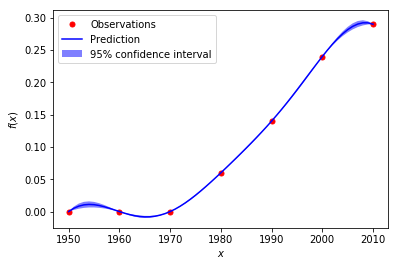

In [292]:
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

### nope - I stick with the interpolation.